# Reinforcement Learning

In the last exercise session, we have seen ways to solve the prediction and control problems for a sequential decision-making task modeled with a known MDP.

In this exercise session, we consider a similar setting except that the underlying MDP is now unknwon. Can we still solve the prediction and control problems from sampled interactions with the environemnt?



## Environment and Transition Model

In reinforcement learning, the full MDP model is not available to the agent. Instead, we define an environment class that only exposes the *transition model* of the MDP in a black-box method. This method takes as input the action selected by the agent and it returns the next state observation along with the immediate reward.

Let us define the environment class for the same *Advertising Problem* that we considered in the last exercise session.

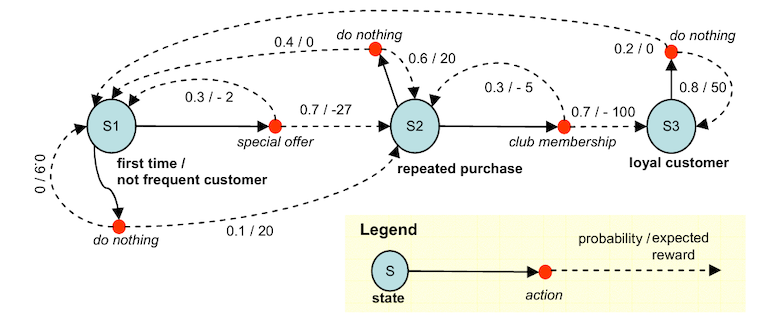

In [ ]:
import numpy as np

class Environment(object):

  def __init__(self):
    # states and actions
    self.nS = 3
    self.nA = 3
    self.allowed_actions = np.array([[1, 1, 0], [1, 0, 1], [1, 0, 0]])
    # initial state distribution and discount factor
    self.mu = np.array([1., 0., 0.])
    self.gamma = 0.9
    # transition model (SA rows, S columns)
    self.P = np.array([[0.9, 0.1, 0.],
                      [0.3, 0.7, 0.],
                      [0., 0., 0.],
                      [0.4, 0.6, 0.],
                      [0., 0., 0.],
                      [0., 0.3, 0.7],
                      [0.2, 0, 0.8],
                      [0., 0., 0.],
                      [0., 0., 0.]])
    # immediate reward (SA rows, S columns)
    self.R = np.array([[0, 20, 0],
                      [-2, -27, 0],
                      [0., 0., 0.],
                      [0, 20, 0],
                      [0., 0., 0.],
                      [0, -5, -100],
                      [0, 0, 50],
                      [0., 0., 0.],
                      [0., 0., 0.]])
  
  # method to set the environment random seed
  def _seed(self, seed):
    np.random.seed(seed)
    
  # method to reset the environment to the initial state
  def reset(self):
    self.s = s = np.random.choice(self.nS, p=self.mu)
    return s

  # method to perform an environemnt transition
  def transition_model(self, a):
    sa = self.s * self.nA + a
    self.s = s_prime = np.random.choice(self.nS, p=self.P[sa, :])
    inst_rew = self.R[sa, s_prime]
    return s_prime, inst_rew


Having defined the class, we can instantiate an environment object and interact with it. For example, with a fixed policy that always selects the action *do-nothing*, we get:

In [ ]:
env = Environment()
# env._seed(0) # set a seed to have reproducible results

T = 10 # interaction steps
a = 0 # policy with a fixed action

ret = 0 # return initialization
s = env.reset()
print('step', 0, 's:', s)
for i in range(T):
  s, r = env.transition_model(a)
  ret = ret + r * (env.gamma ** (i+1))
  print('\nstep:', i+1, 's:', s, 'a:', a, 'r:', r)
print('\nthe final return is:', ret)

step 0 s: 0

step: 1 s: 0 a: 0 r: 0.0

step: 2 s: 0 a: 0 r: 0.0

step: 3 s: 0 a: 0 r: 0.0

step: 4 s: 0 a: 0 r: 0.0

step: 5 s: 0 a: 0 r: 0.0

step: 6 s: 0 a: 0 r: 0.0

step: 7 s: 0 a: 0 r: 0.0

step: 8 s: 0 a: 0 r: 0.0

step: 9 s: 0 a: 0 r: 0.0

step: 10 s: 1 a: 0 r: 20.0

the final return is: 6.973568802000002


## Reinforcement Learning for Prediction

In the last exercise session, we have seen methods (i.e., the exact solution and the recursive formulation of the Bellman expectation equation) to evaluate the performance $V^\pi$ of a fixed policy $\pi$. Without the knwoledge of the MDP, we can evaluate a given policy $\pi$ by sampling a batch of interactions from the environment and performing a Temporal Difference (TD) estimation:
$$
  V (s) \gets  V (s) + \alpha \big( r + \gamma V (s') - V (s)  \big). 
$$

First, we define the *far-sighted* policy we aim to evaluate:

In [ ]:
# far-sighted policy
pi_far = np.array([[0., 1., 0.],
                   [0., 0., 1.],
                   [1., 0., 0.]])

Then, we sample interactions with an instance of the Environment class and we update the value function estimate:

In [ ]:
import numpy as np

# instantiate the environment
env = Environment()
# env._seed(9)
# learning parameters
M = 5000
m = 1
# initial V function
V = np.zeros(env.nS)
actions = [0, 1, 2]

# initial state and action
s = env.reset()
# TD evaluation
while m < M:
  alpha = (1 - m/M)
  # environment step
  a = np.random.choice(actions, p=pi_far[s])
  s_prime, r = env.transition_model(a)
  # TD update
  V[s] = V[s] + alpha * (r + env.gamma * V[s_prime] - V[s])
  # next iteration
  m = m + 1
  s = s_prime

print('The final V function is:\n', V)

The final V function is:
 [-16.54086039  26.9534049  142.14518994]


Since the TD estimator is consistent, $V$ would converge to the actual $V^\pi$ with a sufficiently large number of samples.

## Reinforcement Learning for Control

In the last exercise session, we have seen methods (i.e., brute force, policy iteration, value iteration) to compute an optimal policy $\pi^* \in \arg \max_{\pi \in \Pi} V^\pi (s), \forall s \in \mathcal{S}$ for a given MDP. Without the knowledge of the MDP, can we still find an (approximately) optimal policy from mere interactions with the environment?

Reinforcement learning gives a positive answer to this crucial question. Especially, we are going to implement two remarkable methods:
1.   *SARSA*, which combines TD evaluation with $\epsilon$-greedy policy improvemnt. It is in a way an empirical policy iteration procedure;
2.   *Q-learning*, which embeds TD estimation into a typical value iteration update.



### SARSA

To implement SARSA, we need three elements:
- a dataset or a generative process (which we can get from the environment class defined above);
- a policy improvement step ($\epsilon$-greedy policy);
- an evaluation step (TD estimate update).

First, we define the $\epsilon$-greedy policy as a function that takes as input the current state $s$ and the current $Q$ function estimate and returns the selected action:

In [ ]:
def eps_greedy(s, Q, eps, allowed_actions):
  if np.random.rand() <= eps:
    actions = np.where(allowed_actions)
    actions = actions[0] # just keep the indices of the allowed actions
    a = np.random.choice(actions, p=(np.ones(len(actions)) / len(actions)))
  else:
    Q_s = Q[s, :].copy()
    Q_s[allowed_actions == 0] = - np.inf
    a = np.argmax(Q_s)
  return a

Then, we define the TD update as before, but we now consider an estimate of the $Q$ function instead of $V$, which is given by:
$$
  Q (s, a) \gets Q (s, a) + \alpha \big( r + \gamma Q (s', a') - Q (s, a)  \big),
$$
and we combine the three components in the *SARSA* algorithm:

In [ ]:
import numpy as np

# instantiate the environment
env = Environment()
env._seed(10)
# learning parameters
M = 5000
m = 1
# initial Q function
Q = np.zeros((env.nS, env.nA))

# initial state and action
s = env.reset()
a = eps_greedy(s, Q, 1., env.allowed_actions[s])
# SARSA main loop
while m < M:
  alpha = (1 - m/M)
  eps = (1 - m/M) ** 2
  # environment step
  s_prime, r = env.transition_model(a)
  # policy improvement step
  a_prime = eps_greedy(s, Q, eps, env.allowed_actions[s_prime])
  # SARSA update (evaluation step)
  Q[s, a] = Q[s, a] + alpha * (r + env.gamma * Q[s_prime, a_prime] - Q[s, a])
  # next iteration
  m = m + 1
  s = s_prime
  a = a_prime

print('The final Q function is:\n', Q)

The final Q function is:
 [[40.22746377  8.5816356   0.        ]
 [67.39322817  0.          6.08671501]
 [79.70051083  0.          0.        ]]


At this link you can find an illustrative video of the $Q$ estimation through the SARSA updates:

https://drive.google.com/file/d/1-p_GyX2fsA1Dj3YX1FfcSoDfrHiFNNlw/view?usp=sharing

### Q-learning

To implement Q-learning, we just need to take the SARSA algorithm above and to substitute the SARSA update with the Q-learning update, which is a TD approximation of the Bellman optimality equation:
$$
  Q (s, a) \gets Q (s, a) + \alpha \big( r + \gamma \max_{\widetilde{a} \in \mathcal{A}} Q (s', \widetilde{a}) - Q (s, a)  \big). 
$$

In [ ]:
import numpy as np

# instantiate the environment
env = Environment()
env._seed(10)
# learning parameters
M = 5000
m = 1
# initial Q function
Q = np.zeros((env.nS, env.nA))

# initial state and action
s = env.reset()
a = eps_greedy(s, Q, 1., env.allowed_actions[s])
# Q-learning main loop
while m < M:
  alpha = (1 - m/M)
  eps = (1 - m/M) ** 2
  # environment step
  s_prime, r = env.transition_model(a)
  # policy improvement step
  a_prime = eps_greedy(s, Q, eps, env.allowed_actions[s_prime])
  # Q-learning update
  Q[s, a] = Q[s, a] + alpha * (r + env.gamma * np.max(Q[s_prime, :]) - Q[s, a])
  # next iteration
  m = m + 1
  s = s_prime
  a = a_prime

print('The final Q function is:\n', Q)

The final Q function is:
 [[ 41.15690117  25.13753528   0.        ]
 [ 68.68305032   0.          28.26528974]
 [127.83597797   0.           0.        ]]


At this link you can find an illustrative video of the $Q$ estimation through the Q-learning updates:

https://drive.google.com/file/d/1RvwWCpr-QAkMVwRWFaq2YjXxMAl9DWvN/view?usp=sharing

## Homeworks

Here we propose some additional exercises in Python for you. They are not mandatory, but they can be helpful to better understand the contents of the lecture.

### Monte-Carlo Prediction and Control

Try to solve the same prediction and control problems we have considered with Monte-Carlo value functions estimation instead of TD.

### Off-Policy Monte-Carlo Prediction

Try to evaluate the *far-sighted* policy by sampling interactions with a different policy (hint, try with a uniform policy). How do you have to modify the Monte-Carlo update to get an unbiased estimate? 

### Environment Class Definition

Try to define the environment class for the MDP depicted below. Then, use the code we implemented above to (approximately) solve a prediction and control problem from samples interactions with this new environment.

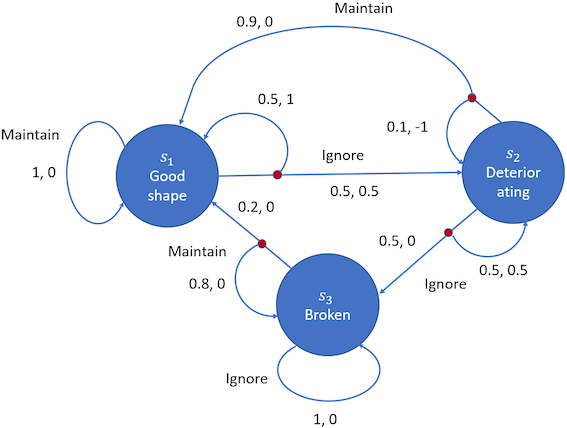